In [4]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from dotenv import load_dotenv


from collab_data.file_utils import expand_path, get_project_root
from collab_data.gcs_utils import GCSClient 

### Setup API keys

In [5]:
# Load environment variables from .env file
load_dotenv()

gerbils_key = os.environ.get("COLLAB_GERBILS_KEY")
data_key = os.environ.get("COLLAB_DATA_KEY")

print(f"Gerbils key: {gerbils_key}")
print(f"Data key: {data_key}")

Gerbils key: /workspace/api-keys/collab-gerbils-444419-2c6aa9a47bb5.json
Data key: /workspace/api-keys/collab-data-463313-c340ad86b28e.json


### Download an RGB video

In [6]:
CURRENT_PROJECT = "COLLAB_DATA"
PROJECT_KEY = Path(os.environ.get(f"{CURRENT_PROJECT}_KEY"))
PROJECT_ID = "-".join(PROJECT_KEY.stem.split("-")[:-1])

# Connect to GCS
gcs_client = GCSClient(
    project_id=PROJECT_ID,
    credentials_path=expand_path(PROJECT_KEY.as_posix(), get_project_root()),
)

2025-07-25 21:29:54.880 | INFO     | collab_data.gcs_utils:__init__:34 - Using credentials from /workspace/api-keys/collab-data-463313-c340ad86b28e.json
2025-07-25 21:29:54.939 | INFO     | collab_data.gcs_utils:__init__:40 - Using project collab-data-463313


Find all buckets and grab the videos for the desired session

In [8]:
CURRENT_SESSION = "2024_02_06"
CURRENT_BUCKET = gcs_client.list_buckets()[-1]
DTYPE = 'processed'

assert DTYPE in CURRENT_BUCKET, "Current bucket is not the processed bucket"

# Grab the aligned frames for the current session
current_session_dir = gcs_client.glob(f"{CURRENT_BUCKET}/{CURRENT_SESSION}*")[0]
aligned_dir = Path(current_session_dir) / "aligned_frames" / "rgb_1" 
aligned_fn = gcs_client.glob(f"{aligned_dir.as_posix()}/*adjusted*")[0]

# Set the current output directory
local_out_dir = Path("/workspace/fieldwork-data/birds/2024-02-06") 
local_aligned_dir = local_out_dir / aligned_dir.relative_to(current_session_dir) 
local_out_fn = local_aligned_dir / Path(aligned_fn).name

# # Download the file
# gcs_client.gcs.get_file(
#     rpath=aligned_fn,
#     lpath=local_out_fn.as_posix(),
# )

### Now load the video

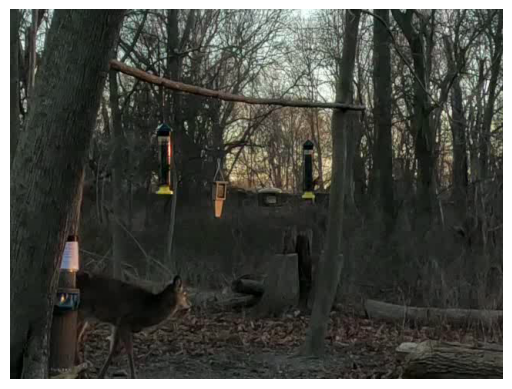

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture(local_out_fn)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    break

# Double check the frame is correct
plt.imshow(frame)
plt.axis('off')
plt.show()

Write a frame out

In [10]:
# al = (local_out_dir / "aligned_frames/rgb_1/")
sampled_frames_dir = local_aligned_dir / "sampled"
os.makedirs(sampled_frames_dir, exist_ok=True)

out_fn = sampled_frames_dir / "0001.png"
frame_out = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
cv2.imwrite(out_fn, frame_out)

# Write out frame names to a .txt file
with open(local_aligned_dir / "frames.txt", "w") as f:
    f.write(str(out_fn) + "\n")

### Import hloc

In [12]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, pairs_from_exhaustive
from hloc.utils.viz import plot_images
from hloc.utils.io import get_keypoints, get_matches
import pycolmap
# from hloc.utils.parsers import parse_retrieval, parse_localization_results


Configuration

In [40]:
from tqdm import tqdm
import shutil
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

def align_to_splat(
    preproc_dir: Path,
    query_dir: Path,
    output_dir: Path,
):
    """
    Align a SfM model to a new set of images.

    Args:
        preproc_dir: Path to the source directory containing the SfM model.
        query_dir: Path to the query directory containing the new images.
        output_dir: Path to the output directory.
    """

    #########################################################
    ############ Grab original model information ############
    #########################################################
    
    # Contains the points3D.bin and images.bin
    colmap_path = preproc_dir / "colmap/"

    # Path to the original training information
    model_path = colmap_path / "sparse/0/"
    model_images = preproc_dir / "images/"  # Existing images used in the SfM model
    model_features = colmap_path / "features.h5"
    model_matches = colmap_path / "matches.h5"

     # Load the COLMAP model and find the images used for its training
    model = pycolmap.Reconstruction(model_path)
    references_registered = [model.images[i].name for i in model.reg_image_ids()]

    ##########################################
    ############ Query setup #################
    ##########################################

    print (f"Creating output directory...")
    output_dir.mkdir(exist_ok=True, parents=True)

    # Define paths for queries    
    query_features = output_dir / "features.h5"
    query_matches = output_dir / "matches.h5"
    query_pairs = output_dir / "pairs-loc.txt"
    query_images_list = [image.name for image in query_dir.glob("*")]

    # Copy over original files as to not overwrite / alter
    shutil.copy(src=model_features, dst=query_features)
    shutil.copy(src=model_matches, dst=query_matches)

    ######################################################
    ###### Feature extraction and keypoint matching ######
    ######################################################

    print (f"Extracting features from queries and matching...")

    # Feature and matcher config
    feature_conf = extract_features.confs['superpoint_aachen']
    matcher_conf = match_features.confs['superglue']

    # Extracts features and writes the to the query_features file
    extract_features.main(
        conf=feature_conf, 
        image_dir=query_dir, 
        feature_path=query_features, 
        image_list=query_images_list,
        overwrite=True,
    )

    # Find every set of pairs of reference images and query images (writes to file)
    pairs_from_exhaustive.main(
        query_pairs,
        image_list=query_images_list,
        ref_list=references_registered
    )

    # Adds query information into the matches file
    match_features.main(
        matcher_conf,
        query_pairs,
        features=query_features,
        matches=query_matches,
        overwrite=True
    )

    ######################################################
    ################## Localization #####################
    ######################################################

    # Define the localization configuration
    localization_conf = {
        'estimation': {'ransac': {'max_error': 12}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    }

    localizer = QueryLocalizer(model, localization_conf)

    # Go through each query image and localize it
    for image in tqdm(query_images_list, desc="Localizing query images..."):

        # Create a camera from the image (i.e., FOV, principal point, etc.)
        camera = pycolmap.infer_camera_from_image(query_dir / image)
        ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]

        ret, log = pose_from_cluster(localizer, image, camera, ref_ids, query_features, query_matches)

    return ret, log

In [41]:
base_dir = Path("/workspace/fieldwork-data/birds/2024-02-06/")
preproc_dir = base_dir / "environment/C0043/preproc/"

# Path to query images and output directory
query_dir = base_dir / "aligned_frames/rgb_1/sampled/"
output_dir = base_dir / "aligned_splat/rgb_1/"

ret, loc = align_to_splat(
    preproc_dir=preproc_dir,
    query_dir=query_dir,
    output_dir=output_dir
)

Creating output directory...


[2025/07/25 21:49:28 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Extracting features from queries and matching...
Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2025/07/25 21:49:29 hloc INFO] Finished exporting features.
[2025/07/25 21:49:29 hloc INFO] Found 597 pairs.
[2025/07/25 21:49:29 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/597 [00:00<?, ?it/s]

[2025/07/25 21:50:18 hloc INFO] Finished exporting matches.


Localizing query images...:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
loc

{'db': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  1